# Loads (Notice git integration)

In [0]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 2.7MB/s 


In [0]:
!nvidia-smi

Mon Jun  8 09:52:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/MathiasNT/DEwNF
   04e5625..cc926fb  master     -> origin/master
Updating 04e5625..cc926fb
Fast-forward
 semisup_no_semi_searchlog_script.py        | 337 ++++++++++++++++++++++++++++
 semisup_no_semi_searchlog_script_combi.py  | 337 ++++++++++++++++++++++++++++
 semisup_no_semi_searchlog_script_planar.py | 339 +++++++++++++++++++++++++++++
 3 files changed, 1013 insertions(+)
 create mode 100644 semisup_no_semi_searchlog_script.py
 create mode 100644 semisup_no_semi_searchlog_script_combi.py
 create mode 100644 semisup_no_semi_searchlog_script_planar.py
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
#from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling
from DEwNF.flows import inverted_conditional_planar_flow_factory

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [0]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Define planar flow
code also in python package but put here as to be able to load trained flows

In [0]:
# Based upon implementation from Uber Technologies - Their trademark is below
# Copyright (c) 2017-2019 Uber Technologies, Inc.
# SPDX-License-Identifier: Apache-2.0

import math

import torch
import torch.nn as nn
from torch.distributions import constraints
import torch.nn.functional as F

from torch.distributions import Transform
from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule
from pyro.distributions.util import copy_docs_from
from pyro.nn import DenseNN

from pyro.distributions.transforms import permute, batchnorm

@copy_docs_from(Transform)
class InvertedConditionedPlanar(Transform):
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, bias=None, u=None, w=None):
        super().__init__(cache_size=1)
        self.bias = bias
        self.u = u
        self.w = w
        self._cached_logDetJ = None

    # This method ensures that torch(u_hat, w) > -1, required for invertibility
    def u_hat(self, u, w):
        alpha = torch.matmul(u.unsqueeze(-2), w.unsqueeze(-1)).squeeze(-1)
        a_prime = -1 + F.softplus(alpha)
        return u + (a_prime - alpha) * w.div(w.pow(2).sum(dim=-1, keepdim=True))

    def _call(self, x):
        """
        :param y: the output of the bijection
        :type y: torch.Tensor
        Inverts y => x. As noted above, this implementation is incapable of
        inverting arbitrary values `y`; rather it assumes `y` is the result of a
        previously computed application of the bijector to some `x` (which was
        cached on the forward call)
        """

        raise KeyError("ConditionedPlanar object expected to find key in intermediates cache but didn't")
        

    def _inverse(self, y):
        """
        :param x: the input into the bijection
        :type x: torch.Tensor
        Invokes the bijection x => y; in the prototypical context of a
        :class:`~pyro.distributions.TransformedDistribution` `x` is a sample from
        the base distribution (or the output of a previous transform)
        """

        # x ~ (batch_size, dim_size, 1)
        # w ~ (batch_size, 1, dim_size)
        # bias ~ (batch_size, 1)
        act = torch.tanh(torch.matmul(self.w.unsqueeze(-2), y.unsqueeze(-1)).squeeze(-1) + self.bias)
        u_hat = self.u_hat(self.u, self.w)
        x = y + u_hat * act

        psi_z = (1. - act.pow(2)) * self.w
        self._cached_logDetJ = torch.log(
            torch.abs(1 + torch.matmul(psi_z.unsqueeze(-2), u_hat.unsqueeze(-1)).squeeze(-1).squeeze(-1)))
        return x

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the elementwise determinant of the log Jacobian
        """
        x_old, y_old = self._cached_x_y
        if x is not x_old or y is not y_old:
            # This call to the parent class Transform will update the cache
            # as well as calling self._call and recalculating y and log_detJ
            self._inverse(y)

        return -self._cached_logDetJ

class InvertedConditionalPlanar(ConditionalTransformModule):
    """
    A conditional 'planar' bijective transform using the equation,

        :math:`\\mathbf{y} = \\mathbf{x} + \\mathbf{u}\\tanh(\\mathbf{w}^T\\mathbf{z}+b)`

    where :math:`\\mathbf{x}` are the inputs with dimension :math:`D`,
    :math:`\\mathbf{y}` are the outputs, and the pseudo-parameters
    :math:`b\\in\\mathbb{R}`, :math:`\\mathbf{u}\\in\\mathbb{R}^D`, and
    :math:`\\mathbf{w}\\in\\mathbb{R}^D` are the output of a function, e.g. a NN,
    with input :math:`z\\in\\mathbb{R}^{M}` representing the context variable to
    condition on. For this to be an invertible transformation, the condition
    :math:`\\mathbf{w}^T\\mathbf{u}>-1` is enforced.

    Together with :class:`~pyro.distributions.ConditionalTransformedDistribution`
    this provides a way to create richer variational approximations.

    Example usage:

    >>> from pyro.nn.dense_nn import DenseNN
    >>> input_dim = 10
    >>> context_dim = 5
    >>> batch_size = 3
    >>> base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
    >>> param_dims = [1, input_dim, input_dim]
    >>> hypernet = DenseNN(context_dim, [50, 50], param_dims)
    >>> transform = ConditionalPlanar(hypernet)
    >>> z = torch.rand(batch_size, context_dim)
    >>> flow_dist = dist.ConditionalTransformedDistribution(base_dist,
    ... [transform]).condition(z)
    >>> flow_dist.sample(sample_shape=torch.Size([batch_size])) # doctest: +SKIP

    The inverse of this transform does not possess an analytical solution and is
    left unimplemented. However, the inverse is cached when the forward operation is
    called during sampling, and so samples drawn using the planar transform can be
    scored.

    :param nn: a function inputting the context variable and outputting a triplet of
        real-valued parameters of dimensions :math:`(1, D, D)`.
    :type nn: callable

    References:
    [1] Variational Inference with Normalizing Flows [arXiv:1505.05770]
    Danilo Jimenez Rezende, Shakir Mohamed

    """

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def condition(self, context):
        bias, u, w = self.nn(context)
        return InvertedConditionedPlanar(bias, u, w)

def inverted_conditional_planar(input_dim, context_dim, hidden_dims=None):
    """
    A helper function to create a
    :class:`~pyro.distributions.transforms.ConditionalPlanar` object that takes care
    of constructing a dense network with the correct input/output dimensions.

    :param input_dim: Dimension of input variable
    :type input_dim: int
    :param context_dim: Dimension of context variable
    :type context_dim: int
    :param hidden_dims: The desired hidden dimensions of the dense network. Defaults
        to using [input_dim * 10, input_dim * 10]
    :type hidden_dims: list[int]

    """

    if hidden_dims is None:
        hidden_dims = [input_dim * 10, input_dim * 10]
    nn = DenseNN(context_dim, hidden_dims, param_dims=[1, input_dim, input_dim])
    return InvertedConditionalPlanar(nn)



class InvertedPlanar(InvertedConditionedPlanar, TransformModule):
    """
    A 'planar' bijective transform with equation,

        :math:`\\mathbf{y} = \\mathbf{x} + \\mathbf{u}\\tanh(\\mathbf{w}^T\\mathbf{z}+b)`

    where :math:`\\mathbf{x}` are the inputs, :math:`\\mathbf{y}` are the outputs,
    and the learnable parameters are :math:`b\\in\\mathbb{R}`,
    :math:`\\mathbf{u}\\in\\mathbb{R}^D`, :math:`\\mathbf{w}\\in\\mathbb{R}^D` for
    input dimension :math:`D`. For this to be an invertible transformation, the
    condition :math:`\\mathbf{w}^T\\mathbf{u}>-1` is enforced.

    Together with :class:`~pyro.distributions.TransformedDistribution` this provides
    a way to create richer variational approximations.

    Example usage:

    >>> base_dist = dist.Normal(torch.zeros(10), torch.ones(10))
    >>> transform = Planar(10)
    >>> pyro.module("my_transform", transform)  # doctest: +SKIP
    >>> flow_dist = dist.TransformedDistribution(base_dist, [transform])
    >>> flow_dist.sample()  # doctest: +SKIP

    The inverse of this transform does not possess an analytical solution and is
    left unimplemented. However, the inverse is cached when the forward operation is
    called during sampling, and so samples drawn using the planar transform can be
    scored.

    :param input_dim: the dimension of the input (and output) variable.
    :type input_dim: int

    References:

    [1] Danilo Jimenez Rezende, Shakir Mohamed. Variational Inference with
    Normalizing Flows. [arXiv:1505.05770]

    """

    domain = constraints.real
    codomain = constraints.real
    bijective = True
    event_dim = 1

    def __init__(self, input_dim):
        super().__init__()

        self.bias = nn.Parameter(torch.Tensor(1,))
        self.u = nn.Parameter(torch.Tensor(input_dim,))
        self.w = nn.Parameter(torch.Tensor(input_dim,))
        self.input_dim = input_dim
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.u.size(0))
        self.w.data.uniform_(-stdv, stdv)
        self.u.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()

In [0]:
from DEwNF.flows.ConditionalNormalizingFlowWrapper3 import ConditionalNormalizingFlowWrapper3

def conditional_planar_flow_factory(flow_depth, problem_dim, c_net_depth, c_net_h_dim, context_dim,
                                          context_n_h_dim, context_n_depth, rich_context_dim, batchnorm_momentum, cuda,
                                          coupling_dropout=None, context_dropout=None):
    if cuda:
        base_dist = dist.Normal(torch.zeros(problem_dim).cuda(), torch.ones(problem_dim).cuda())
    else:
        base_dist = dist.Normal(torch.zeros(problem_dim), torch.ones(problem_dim))

    # We define the transformations
    transforms = [inverted_conditional_planar(input_dim=problem_dim,
                                              context_dim=rich_context_dim,
                                              hidden_dims=[c_net_h_dim for i in range(c_net_depth)], # Note array here to create multiple layers in DenseNN
                                            )
                  for i in range(flow_depth)]



    # If we want batchnorm add those in. Then sandwich the steps together to a flow
    if batchnorm_momentum is None:
        batchnorms = None
        flows = transforms
    else:
        batchnorms = [batchnorm(input_dim=problem_dim, momentum=batchnorm_momentum) for i in range(flow_depth)]
        for bn in batchnorms:
            bn.gamma.data += torch.ones(problem_dim)
        flows = list(itertools.chain(*zip(batchnorms, transforms)))[1:]


    # We define the conditioning network
    context_hidden_dims = [context_n_h_dim for i in range(context_n_depth)]
    if context_dropout is None:
        condinet = DenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim])
    else:
        condinet = DropoutDenseNN(input_dim=context_dim, hidden_dims=context_hidden_dims, param_dims=[rich_context_dim],
                                  dropout=context_dropout)
    # We define the normalizing flow wrapper
    normalizing_flow = ConditionalNormalizingFlowWrapper3(transforms, flows, base_dist, condinet, batchnorms)
    if cuda:
        normalizing_flow.cuda()

    return normalizing_flow

# Visualize model

In [0]:
affine_4 = 'rotating_two_moons_model_4_layers'
affine_24 = 'rotating_two_moons_model_24_layers'
affine_48 = 'rotating_two_moons_model_48_layers'

planar_4 = "planar_flow1_4"
planar_24 = "planar_flow3_2"
planar_48 = "planar_flow4_2"

combi_4 = 'combi_flow2_4_2'
combi_24 = "combi_flow2_24_2"
combi_48 = "combi_flow2_48_4"

In [0]:
affine_4_path = f"{root_path}/plot_notebooks/models_for_plots/{affine_4}"
affine_24_path = f"{root_path}/plot_notebooks/models_for_plots/{affine_24}"
affine_48_path = f"{root_path}/plot_notebooks/models_for_plots/{affine_48}"

planar_4_path = f"{root_path}/plot_notebooks/models_for_plots/{planar_4}"
planar_24_path = f"{root_path}/plot_notebooks/models_for_plots/{planar_24}"
planar_48_path = f"{root_path}/plot_notebooks/models_for_plots/{planar_48}"

combi_4_path = f"{root_path}/plot_notebooks/models_for_plots/{combi_4}"
combi_24_path = f"{root_path}/plot_notebooks/models_for_plots/{combi_24}"
combi_48_path = f"{root_path}/plot_notebooks/models_for_plots/{combi_48}"

In [0]:
# affine
with open(affine_4_path, 'rb') as f:
    loaded_dict = pickle.load(f)
affine_4_model = loaded_dict['model']

with open(affine_24_path, 'rb') as f:
    loaded_dict = pickle.load(f)
affine_24_model = loaded_dict['model']

with open(affine_48_path, 'rb') as f:
    loaded_dict = pickle.load(f)
affine_48_model = loaded_dict['model']

# planar
with open(planar_4_path, 'rb') as f:
    loaded_dict = pickle.load(f)
planar_4_model = loaded_dict['model']

with open(planar_24_path, 'rb') as f:
    loaded_dict = pickle.load(f)
planar_24_model = loaded_dict['model']

with open(planar_48_path, 'rb') as f:
    loaded_dict = pickle.load(f)
planar_48_model = loaded_dict['model']

# combi
with open(combi_4_path, 'rb') as f:
    loaded_dict = pickle.load(f)
combi_4_model = loaded_dict['model']

with open(combi_24_path, 'rb') as f:
    loaded_dict = pickle.load(f)
combi_24_model = loaded_dict['model']

with open(combi_48_path, 'rb') as f:
    loaded_dict = pickle.load(f)
combi_48_model = loaded_dict['model']

In [0]:
# Load data
from DEwNF.utils import split_synthetic
batch_size = 500
data_size = 100000
cuda_exp = True
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [0]:

## interactive plot
plt.rcParams.update({'font.size': 24})
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow, obs_scaler, context_scaler, axs, flow_name=None, depth=None):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  
    axs.scatter(x[:, 0], x[:, 1], c='r', s=2, alpha=0.5, label="Observations")
    #plt.scatter(scaled_xs[:, 0], scaled_xs[:, 1], c='b', s=1)
    axs.set_xlim(bounds[0][0],bounds[1][0])
    axs.set_ylim(bounds[0][1],bounds[1][1])
    axs.set_xticks([])
    axs.set_yticks([])
    test = axs.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    #axs.legend(framealpha=0.3, fontsize=15, markerscale=6)
    #axs.colorbar(test, shrink=0.6)
    if flow_name is not None:
        axs.set_ylabel(flow_name)
    if depth is not None:
        axs.title.set_text(depth)
    return test

In [0]:
theta = 1.5

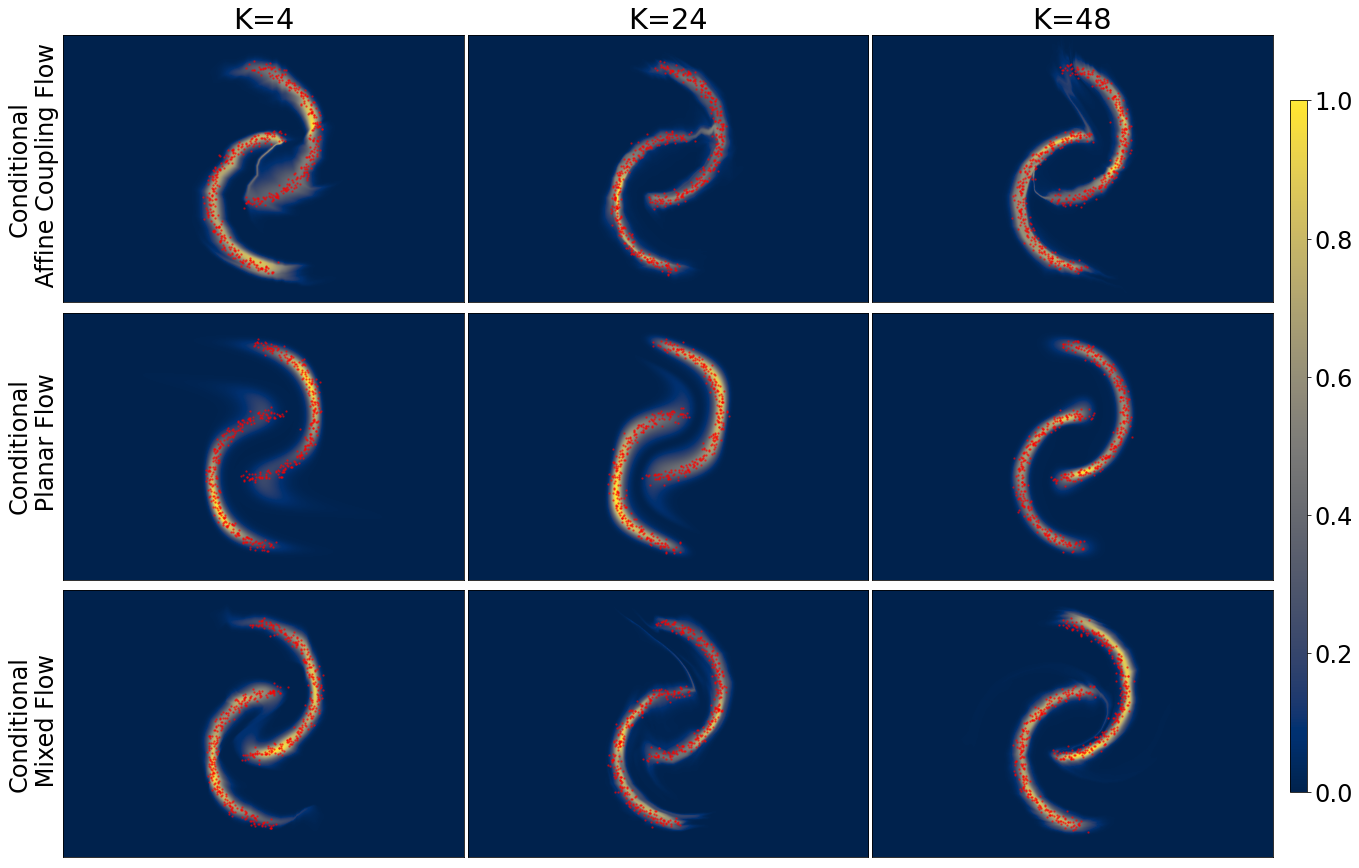

In [0]:
fig, axs = plt.subplots(3, 3,figsize=(24,12))
model_tester3(theta, affine_4_model, obs_scaler, context_scaler, axs[0,0], flow_name=f"Conditional\n Affine Coupling Flow", depth="K=4")
model_tester3(theta, affine_24_model, obs_scaler, context_scaler, axs[0,1], depth="K=24")
model_tester3(theta, affine_48_model, obs_scaler, context_scaler, axs[0,2], depth="K=48")

model_tester3(theta, planar_4_model, obs_scaler, context_scaler, axs[1,0], flow_name="Conditional\n Planar Flow")
model_tester3(theta, planar_24_model, obs_scaler, context_scaler, axs[1,1])
model_tester3(theta, planar_48_model, obs_scaler, context_scaler, axs[1,2])

model_tester3(theta, combi_4_model, obs_scaler, context_scaler, axs[2,0], flow_name="Conditional\n Mixed Flow")
model_tester3(theta, combi_24_model, obs_scaler, context_scaler, axs[2,1])
im = model_tester3(theta, combi_48_model, obs_scaler, context_scaler, axs[2,2])

fig.subplots_adjust(bottom=0, top=1, left=0.1, right=0.8,
                    wspace=0.01, hspace=-0.1)

#cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cb_ax = fig.add_axes([0.81, 0.1, 0.01, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, shrink=0.1)